# Evaluation

This notebook runs ASR on the models.

In [10]:
# Import packages
import pandas as pd
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
import librosa
import editdistance
from g2p_en import G2p
g2p = G2p()
import nltk
#import os

In [11]:
# nltk.download('averaged_perceptron_tagger_en')
# nltk.download('punkt')
g2p = G2p()

In [36]:
def load_audio(file_path):
    '''
    Load audio file from filepath.
    '''
    audio, _ = librosa.load(file_path, sr=16000)
    return audio


def transcribe_audio(model, proc, file_name):
    '''
    Transcribes audio using defined model.
    '''
    audio = load_audio(file_name)
    
    input_vals = proc(
        audio, 
        return_tensors = 'pt',
        sampling_rate = 16000
    ).input_values 

    with torch.no_grad():
        logits = model(input_vals).logits 
        
    predicted_ids = torch.argmax(logits, dim = -1)
    predicted_word = proc.decode(predicted_ids[0])
    
    return predicted_word.lower()


def get_phones(text):
    '''
    Get phones from G2p mapping.
    '''
    phones = g2p(text)
    if " " in phones:
        phones.remove(" ")
    return phones


def compute_phone_edit_distance(predicted, reference):
    '''
    Computes normalized edit distance between predicted phones and true (canonical) phones.
    '''
    return editdistance.eval(predicted, reference) / max(len(reference), 1)


def load_model(model_path):
    '''
    Loads model from local model filepath.
    '''
    model = Wav2Vec2ForCTC.from_pretrained(model_path)
    proc = Wav2Vec2Processor.from_pretrained(model_path)

    return model, proc


def transcribe_dataset(df, models):
    '''
    Makes ASR predictions of audio files for each model. 
    Gets phone mappings of transcription and predictions. 
    Calculates edit distance between prediction phones and true (canonical) phones.

    Parameters: 
    -----------
    df : pandas DataFrame
    models : dictionary of models

    Returns:
    --------
    df : updated DataFrame with predictions, phones, and edit distance for each model.
    '''
    
    # get phones of transcription
    df['transcription_phones'] = df["transcription"].apply(lambda x: get_phones(x))
    
    # get predictions, phones, and edit distance from models
    for i in models.keys():
        model_name = i
        model_path = models[i]

        model, proc = load_model(model_path)

        # get predictions
        pred_col = model_name + '_pred'
        df[pred_col] = df["file_name"].apply(lambda x: transcribe_audio(model, proc, x))
        
        # get phones
        phones_col = model_name + '_phones'
        df[phones_col] = df[pred_col].apply(lambda x: get_phones(x))

        # compute edit distance
        distance_col = model_name + '_edit_distance'
        df[distance_col] = df.apply(
            lambda row: compute_phone_edit_distance(row[phones_col], row['transcription_phones']),
            axis=1
        )

def calculate_accuracy(column, df):
    '''
    Calculate grapheme-based accuracy, proportion of correct predictions over all predictions.
    '''
    num_correct = (df['transcription'] == df[column]).sum()
    num_total = len(df)
    proportion = num_correct/num_total
    return round(proportion, 4)
            


def make_accuracy_df(kids_df, adults_df, model_columns, learning_rates):
    """
    Calculates accuracy and edit distance for kids and adults across different ASR models.

    Parameters:
    -----------
    kids_df : DataFrame containing kids' ASR predictions.
    adults_df : DataFrame containing adults' ASR predictions.
    model_columns : list of prediction column names (e.g., '1e4_pred').
    learning_rates : list of learning rates corresponding to model_columns (same order).

    Returns:
    --------
    accuracy_df : DataFrame with accuracy and mean edit distance for each learning rate and age group.
    """

    metrics = []

    for col, rate in zip(model_columns, learning_rates):
        for group_name, df in zip(["kid_accuracy", "adult_accuracy"], [kids_df, adults_df]):
            
            # calculate accuracy
            accuracy = calculate_accuracy(col, df)
            
            # calculate mean edit distance
            distance_col = col.replace("_pred", "_edit_distance")
            mean_edit_distance = df[distance_col].mean()
            
            # add to metrics list in tidy format
            metrics.append({
                "learning_rate": rate,
                "group": group_name,
                "accuracy": accuracy,
                "mean_edit_distance": mean_edit_distance
            })

    # convert to pandas DataFrame
    return pd.DataFrame(metrics)


In [13]:
kids_df = pd.read_csv("./kids_eval.csv")
adults_df = pd.read_csv("./adults_eval.csv")
models = {
    "0" : "facebook/wav2vec2-base-960h",
    "1e10" : "./w2v2960h_lr1e10",
    "1e9" : "./w2v2960h_lr1e9",
    "1e8" : "./w2v2960h_lr1e8",
    "1e7" : './w2v2960h_lr1e7',
    "1e6" : './w2v2960h_lr1e6',
    "1e5" : './w2v2960h_lr1e5',
    "1e4" : './w2v2960h_lr1e4',
    "1e3" : "./w2v2960h_lr1e3",
    "1e2" : "./w2v2960h_lr1e2"
}

In [14]:
# Run ASR
transcribe_dataset(kids_df, models)
kids_df.to_csv("kids_eval.csv", index=False)

transcribe_dataset(adults_df, models)
adults_df.to_csv("adults_eval.csv", index=False)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
columns = ['0_pred', '1e10_pred','1e9_pred', '1e8_pred', '1e7_pred', '1e6_pred', '1e5_pred', '1e4_pred','1e3_pred','1e2_pred']
rates = [0, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]  # match order

accuracy_df = make_accuracy_df(kids_df, adults_df, columns, rates)
accuracy_df.to_csv("eval_metrics.csv", index=False)
accuracy_df

,learning_rate,group,accuracy,mean_edit_distance
0,0.000000e+00,kid_accuracy,0.1128,0.705054
1,0.000000e+00,adult_accuracy,0.5875,0.223708
2,1.000000e-10,kid_accuracy,0.1128,0.705054
3,1.000000e-10,adult_accuracy,0.5875,0.223708
4,1.000000e-09,kid_accuracy,0.1128,0.705054
5,1.000000e-09,adult_accuracy,0.5875,0.223708
6,1.000000e-08,kid_accuracy,0.1128,0.705890
7,1.000000e-08,adult_accuracy,0.5875,0.223708
8,1.000000e-07,kid_accuracy,0.1153,0.699039
9,1.000000e-07,adult_accuracy,0.5900,0.221417


In [21]:
# dir = "/home/cogsci-lasrlab/Documents/CSS_Capstone/researcher"

# files = []
# words = []

# for file in os.listdir(dir):
#     path = dir+"/"+file
#     files.append(path)

#     if file.endswith('.wav') and "researcher_" in file:
#         base = file[:-4]  # remove '.wav'
#         before, text = base.split("researcher_")

#         words.append(text)

# adults_df = pd.DataFrame({
#     "file_name":files,
#     "transcription":words
# })

# sample_adults_df = adults_df.sample(n=400, random_state=123)
# sample_adults_df

# sample_adults_df.to_csv("adults_eval.csv", index=False)

In [22]:
# columns = ['lr1e4_pred', 'lr1e5_pred', 'lr1e6_pred', 'lr1e7_pred', 'lr1e8_pred', 'lr0_pred']
# columns = columns[::-1]
# rates = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

# kid_accuracy = []
# adult_accuracy = []

# for col in columns:
#     kid_accuracy.append(calculate_accuracy(col, kids_df))
#     adult_accuracy.append(calculate_accuracy(col, adults_df))
    
# accuracy_df = pd.DataFrame({
#     "learning_rate" : rates,
#     "kid_accuracy" : kid_accuracy,
#     "adult_accuracy" : adult_accuracy
# })

# accuracy_df = accuracy_df.melt(
#     id_vars="learning_rate",
#     value_vars=["kid_accuracy", "adult_accuracy"],
#     var_name="group",
#     value_name="accuracy"
# )

# accuracy_df

# Plots

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
sns.set_theme(style="whitegrid", palette="colorblind")

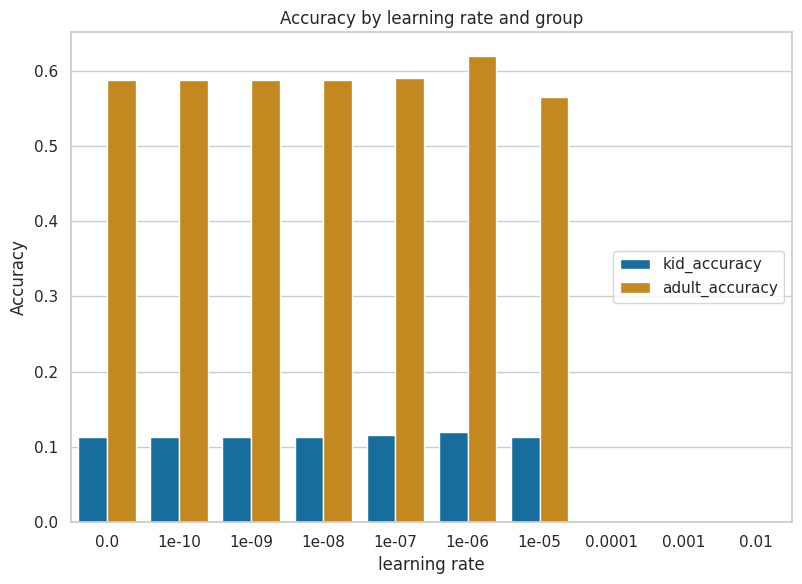

In [40]:
# changing learning rate by an order of magnitude (decrease learning rate logarithmically)
plt.figure(figsize=(10, 6)) 
sns.barplot(accuracy_df, x = 'learning_rate', y= 'accuracy', hue='group')
plt.title("Accuracy by learning rate and group")
plt.xlabel('learning rate')
plt.ylabel("Accuracy")
plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.subplots_adjust(right=0.8)  # shift plot to the left to make space

fig = plt.gcf()

# Save the figure
fig.savefig('accuracy_bar.png', dpi=300)

plt.show()

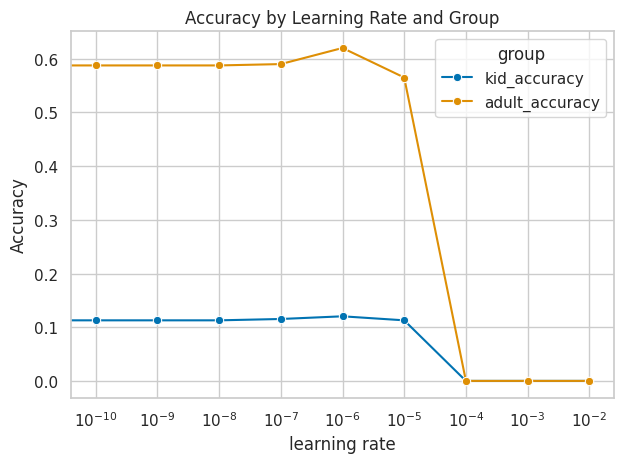

In [41]:
sns.lineplot(data=accuracy_df, x='learning_rate', y='accuracy', hue='group', marker='o')
#plt.xticks(rotation=45)  # optional: rotate x-axis labels if they overlap
plt.title("Accuracy by Learning Rate and Group")
plt.xscale('log')
plt.xlabel('learning rate')
plt.ylabel('Accuracy')
plt.tight_layout()
fig = plt.gcf()

# Save the figure
fig.savefig('accuracy_line.png', dpi=300)

plt.show()

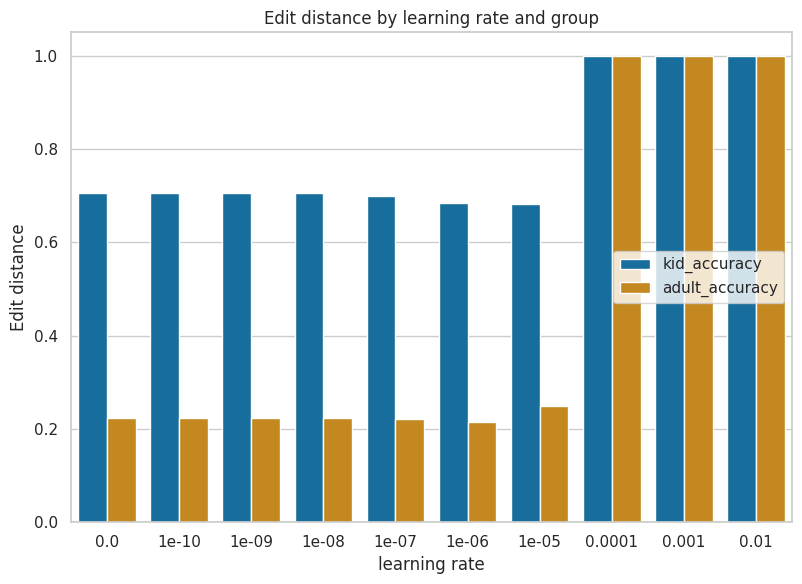

In [42]:
# changing learning rate by an order of magnitude (decrease learning rate logarithmically)
plt.figure(figsize=(10, 6)) 
sns.barplot(accuracy_df, x = 'learning_rate', y= 'mean_edit_distance', hue='group')
plt.title("Edit distance by learning rate and group")
plt.xlabel('learning rate')
plt.ylabel("Edit distance")
plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.subplots_adjust(right=0.8)  # shift plot to the left to make space
fig = plt.gcf()

# Save the figure
fig.savefig('edit_distance_bar.png', dpi=300)

plt.show()

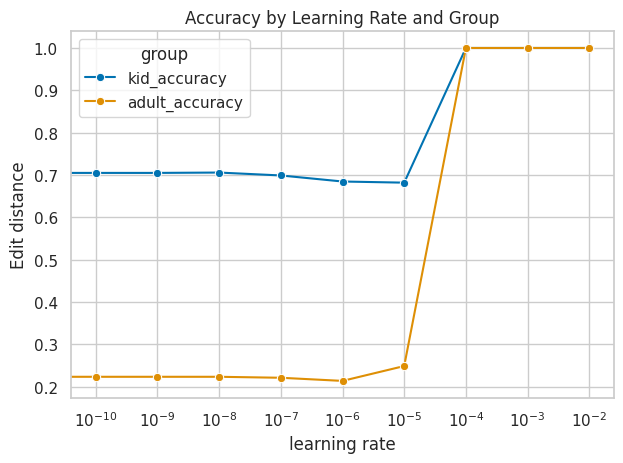

In [43]:
sns.lineplot(data=accuracy_df, x='learning_rate', y='mean_edit_distance', hue='group', marker='o')
#plt.xticks(rotation=45)  # optional: rotate x-axis labels if they overlap
plt.title("Accuracy by Learning Rate and Group")
plt.xscale('log')
plt.xlabel('learning rate')
plt.ylabel('Edit distance')
plt.tight_layout()
fig = plt.gcf()

# Save the figure
fig.savefig('edit_distance_line.png', dpi=300)

plt.show()

In [27]:
accuracy_df

,learning_rate,group,accuracy,mean_edit_distance
0,0.000000e+00,kid_accuracy,0.1128,0.705054
1,0.000000e+00,adult_accuracy,0.5875,0.223708
2,1.000000e-10,kid_accuracy,0.1128,0.705054
3,1.000000e-10,adult_accuracy,0.5875,0.223708
4,1.000000e-09,kid_accuracy,0.1128,0.705054
5,1.000000e-09,adult_accuracy,0.5875,0.223708
6,1.000000e-08,kid_accuracy,0.1128,0.705890
7,1.000000e-08,adult_accuracy,0.5875,0.223708
8,1.000000e-07,kid_accuracy,0.1153,0.699039
9,1.000000e-07,adult_accuracy,0.5900,0.221417


In [85]:
from g2p_en import G2p
g2p = G2p()

def get_phones(text):
    phones = g2p(text)
    if " " in phones:
        phones.remove(" ")
    return phones

In [86]:
get_phones("rar yumow")

['R', 'AA1', 'R', 'Y', 'UW1', 'M', 'OW0']